In [1]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-01-01) 47,337 GO Terms


In [35]:
import pandas as pd
df = pd.read_pickle("human_bp_count")


In [42]:
# remove super large terms
import sys
df.drop(index = df.loc[df['size']>sys.maxsize].index, inplace = True)

In [73]:
df.loc[df['size'].isnull()]

,size,num_children,normalized_entropy


In [87]:
import numpy as np
def term_entropy(term, obodag, count_df):
    '''
    consider child term with 0 gene as 10**-5
    '''
    try:
        children_id = [i.id for i in obodag[term].children]
    except:
        # some obsolete GO term is not in obodag but still propogated by gene2goid
        children_id = []
    children_id = list(set(children_id).intersection(set(count_df.index)))
    no_children = len(children_id)
    count_df.loc[term, 'num_children'] = no_children
    
    
    # normalized entropy since every one don't have the same number of children
    if no_children > 0:
        # fill NaN as 0 because no genes propagate to here; can't fill a real 0 since np.log(0) becomes negative infinity
        child_count = count_df.loc[children_id, 'size'].fillna(10**(-5)).values
        
        child_prob = child_count/np.sum(child_count)
        
        
        normalized_entropy = -np.sum(np.multiply(child_prob, np.log(child_prob))/np.log(no_children))
        count_df.loc[term, 'normalized_entropy'] = normalized_entropy
        
        
        
    

In [88]:
_ = [term_entropy(i, obodag, df) for i in df.index]

/cellar/users/hsher/miniconda3/envs/ontoPrune/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [89]:
df.loc[df['normalized_entropy'].isnull()]
# either leaf term or non-exist(rare)

,size,num_children,normalized_entropy
GO:0043312,481,0.0,NaN
GO:0002283,486,1.0,NaN
GO:0042119,498,1.0,NaN
GO:0002576,124,0.0,NaN
GO:0022617,66,1.0,NaN
...,...,...,...
GO:0032595,1,1.0,NaN
GO:0032600,1,0.0,NaN
GO:0032599,1,1.0,NaN
GO:0033606,1,1.0,NaN


In [90]:
notnull_df = df.loc[df['normalized_entropy'].notnull()]

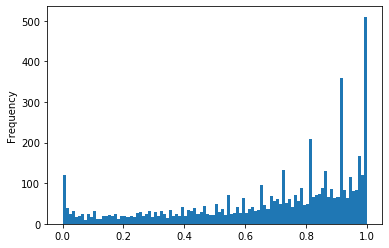

In [93]:
%matplotlib inline
notnull_df['normalized_entropy'].plot.hist(bins = 100)

In [95]:
# what are the terms with low entropy
low_info_term = notnull_df.loc[notnull_df['normalized_entropy']< 0.011].index # last bin

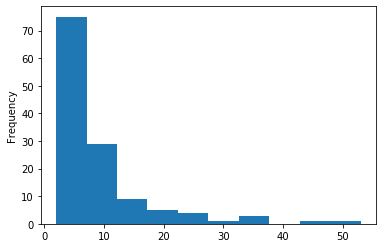

In [96]:
# how many children do they have
notnull_df.loc[low_info_term, 'num_children'].plot.hist()

In [100]:
# let's see what term they are
low_info_names = [obodag[term].name for term in low_info_term]

In [101]:
low_info_names

['cell activation',
 'cell activation involved in immune response',
 'export from cell',
 'establishment of localization',
 'cellular component organization or biogenesis',
 'negative regulation of protein metabolic process',
 'organonitrogen compound metabolic process',
 'primary metabolic process',
 'regulation of innate immune response',
 'regulation of biological quality',
 'positive regulation of cellular process',
 'positive regulation of cell motility',
 'positive regulation of cellular component movement',
 'positive regulation of locomotion',
 'regulation of multicellular organismal process',
 'cell motility',
 'cellular nitrogen compound metabolic process',
 'cellular aromatic compound metabolic process',
 'heterocycle metabolic process',
 'organic cyclic compound metabolic process',
 'cellular nitrogen compound biosynthetic process',
 'aromatic compound biosynthetic process',
 'heterocycle biosynthetic process',
 'organic cyclic compound biosynthetic process',
 'cellular ami

In [103]:
low_info_level = [obodag[term].level for term in low_info_term]
low_info_depth = [obodag[term].depth for term in low_info_term]

(array([ 4., 11., 20.,  0., 43., 28.,  0., 18.,  1.,  3.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

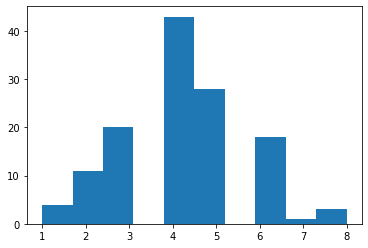

In [104]:
import matplotlib.pyplot as plt
plt.hist(low_info_level)

(array([ 4.,  7., 16., 32.,  0., 27., 29.,  9.,  1.,  3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

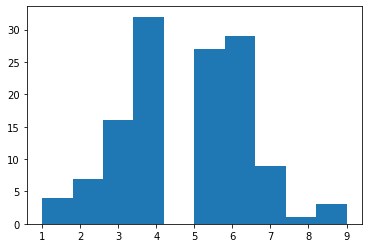

In [105]:
plt.hist(low_info_depth)

In [125]:
# inspect local structure
# print children name, children count
def inspect_local_structure(lterm):
    '''see the distribution of low information term'''
    print(obodag[lterm].name)
    
    child_id = [term.id for term in obodag[lterm].children]
    child_names = [obodag[term].name for term in child_id]
    child_size = df.loc[child_id]
    
    child_size['name'] = child_names
    
    return(child_size)

In [126]:
inspect_local_structure(low_info_term[0])

cell activation


/cellar/users/hsher/miniconda3/envs/ontoPrune/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,size,num_children,normalized_entropy,name
GO:0030168,102.0,0.0,NaN,platelet activation
GO:0002263,527402.0,3.0,0.000842,cell activation involved in immune response
GO:0042118,10.0,1.0,NaN,endothelial cell activation
GO:0007407,NaN,NaN,NaN,neuroblast activation
GO:0045321,146136577.0,6.0,0.058160,leukocyte activation
GO:0072537,5.0,1.0,NaN,fibroblast activation
GO:0007343,2.0,0.0,NaN,egg activation
GO:0032980,1.0,0.0,NaN,keratinocyte activation
GO:0044566,NaN,NaN,NaN,chondrocyte activation
GO:0061900,98.0,2.0,0.968700,glial cell activation


In [127]:
inspect_local_structure(low_info_term[1])

cell activation involved in immune response


/cellar/users/hsher/miniconda3/envs/ontoPrune/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,size,num_children,normalized_entropy,name
GO:0002366,58741.0,2.0,0.303699,leukocyte activation involved in immune response
GO:0002267,NaN,NaN,NaN,follicular dendritic cell activation involved ...
GO:0002265,4.0,0.0,NaN,astrocyte activation involved in immune response
GO:0002264,1.0,0.0,NaN,endothelial cell activation involved in immune...


In [128]:
inspect_local_structure(low_info_term[2])

export from cell


,size,num_children,normalized_entropy,name
GO:0140353,18,1.0,NaN,lipid export from cell
GO:0140115,43,5.0,0.850046,export across plasma membrane
GO:0032940,570574,11.0,0.240550,secretion by cell


In [129]:
inspect_local_structure(low_info_term[3])

establishment of localization


,size,num_children,normalized_entropy,name
GO:0006810,56179408984700,33.0,0.103535,transport
GO:0045184,14537921,5.0,0.133960,establishment of protein localization
GO:0051236,87738,2.0,0.004920,establishment of RNA localization
GO:0051649,9036,12.0,0.468728,establishment of localization in cell
GO:0051656,12236,11.0,0.633750,establishment of organelle localization


In [130]:
inspect_local_structure(low_info_term[4])

cellular component organization or biogenesis


,size,num_children,normalized_entropy,name
GO:0016043,3170313387,27.0,0.492775,cellular component organization
GO:0044085,162,4.0,0.358050,cellular component biogenesis


In [131]:
inspect_local_structure(low_info_term[5])

negative regulation of protein metabolic process


/cellar/users/hsher/miniconda3/envs/ontoPrune/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,size,num_children,normalized_entropy,name
GO:0045567,NaN,NaN,NaN,negative regulation of TRAIL receptor 2 biosyn...
GO:2000258,NaN,NaN,NaN,negative regulation of protein activation cascade
GO:0045565,NaN,NaN,NaN,negative regulation of TRAIL receptor 1 biosyn...
GO:0046986,1.0,0.0,NaN,negative regulation of hemoglobin biosynthetic...
GO:0032269,8227639.0,4.0,0.496428,negative regulation of cellular protein metabo...
GO:0050760,1.0,0.0,NaN,negative regulation of thymidylate synthase bi...
GO:1902992,21.0,3.0,0.645076,negative regulation of amyloid precursor prote...
GO:1903318,108.0,1.0,NaN,negative regulation of protein maturation
GO:0045715,3.0,0.0,NaN,negative regulation of low-density lipoprotein...
GO:0050748,4.0,2.0,1.000000,negative regulation of lipoprotein metabolic p...


In [132]:
inspect_local_structure(low_info_term[7])

primary metabolic process


,size,num_children,normalized_entropy,name
GO:0006099,34,0.0,NaN,tricarboxylic acid cycle
GO:0019538,5980908032394,15.0,0.256138,protein metabolic process
GO:0006520,7244275,10.0,0.488901,cellular amino acid metabolic process
GO:0005975,1327072,6.0,0.802912,carbohydrate metabolic process
GO:0006139,4173131740062062,5.0,0.019752,nucleobase-containing compound metabolic process
GO:0006629,11704100470,6.0,0.027601,lipid metabolic process


In [133]:
inspect_local_structure(low_info_term[8])

regulation of innate immune response


/cellar/users/hsher/miniconda3/envs/ontoPrune/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,size,num_children,normalized_entropy,name
GO:0070424,32.0,4.0,0.977343,regulation of nucleotide-binding oligomerizati...
GO:1905680,NaN,NaN,NaN,regulation of innate immunity memory response
GO:0030451,4.0,2.0,1.000000,"regulation of complement activation, alternati..."
GO:0001868,2.0,1.0,NaN,"regulation of complement activation, lectin pa..."
GO:0060330,47.0,3.0,0.788792,regulation of response to interferon-gamma
GO:2000072,NaN,NaN,NaN,"regulation of defense response to fungus, inco..."
GO:0034121,555.0,10.0,0.811860,regulation of toll-like receptor signaling pat...
GO:0039531,62.0,3.0,0.947353,regulation of viral-induced cytoplasmic patter...
GO:0060338,53.0,2.0,0.992267,regulation of type I interferon-mediated signa...
GO:0060264,7.0,2.0,0.863121,regulation of respiratory burst involved in in...
